# Pitch segmentation for broadcast football image

Author: Almir Soares Firmo Filho

The goal of this notebook is to show how to determine, without using any machine learning concept, the region of the football pitch, meaning the pitch lines; and to detect humans intereacting with the pitch region, within a football broadcast image or video.

The image we picked for the demonstration is from a football match between London clubs Chelsea and Arsenal for the UEFA Europe League.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

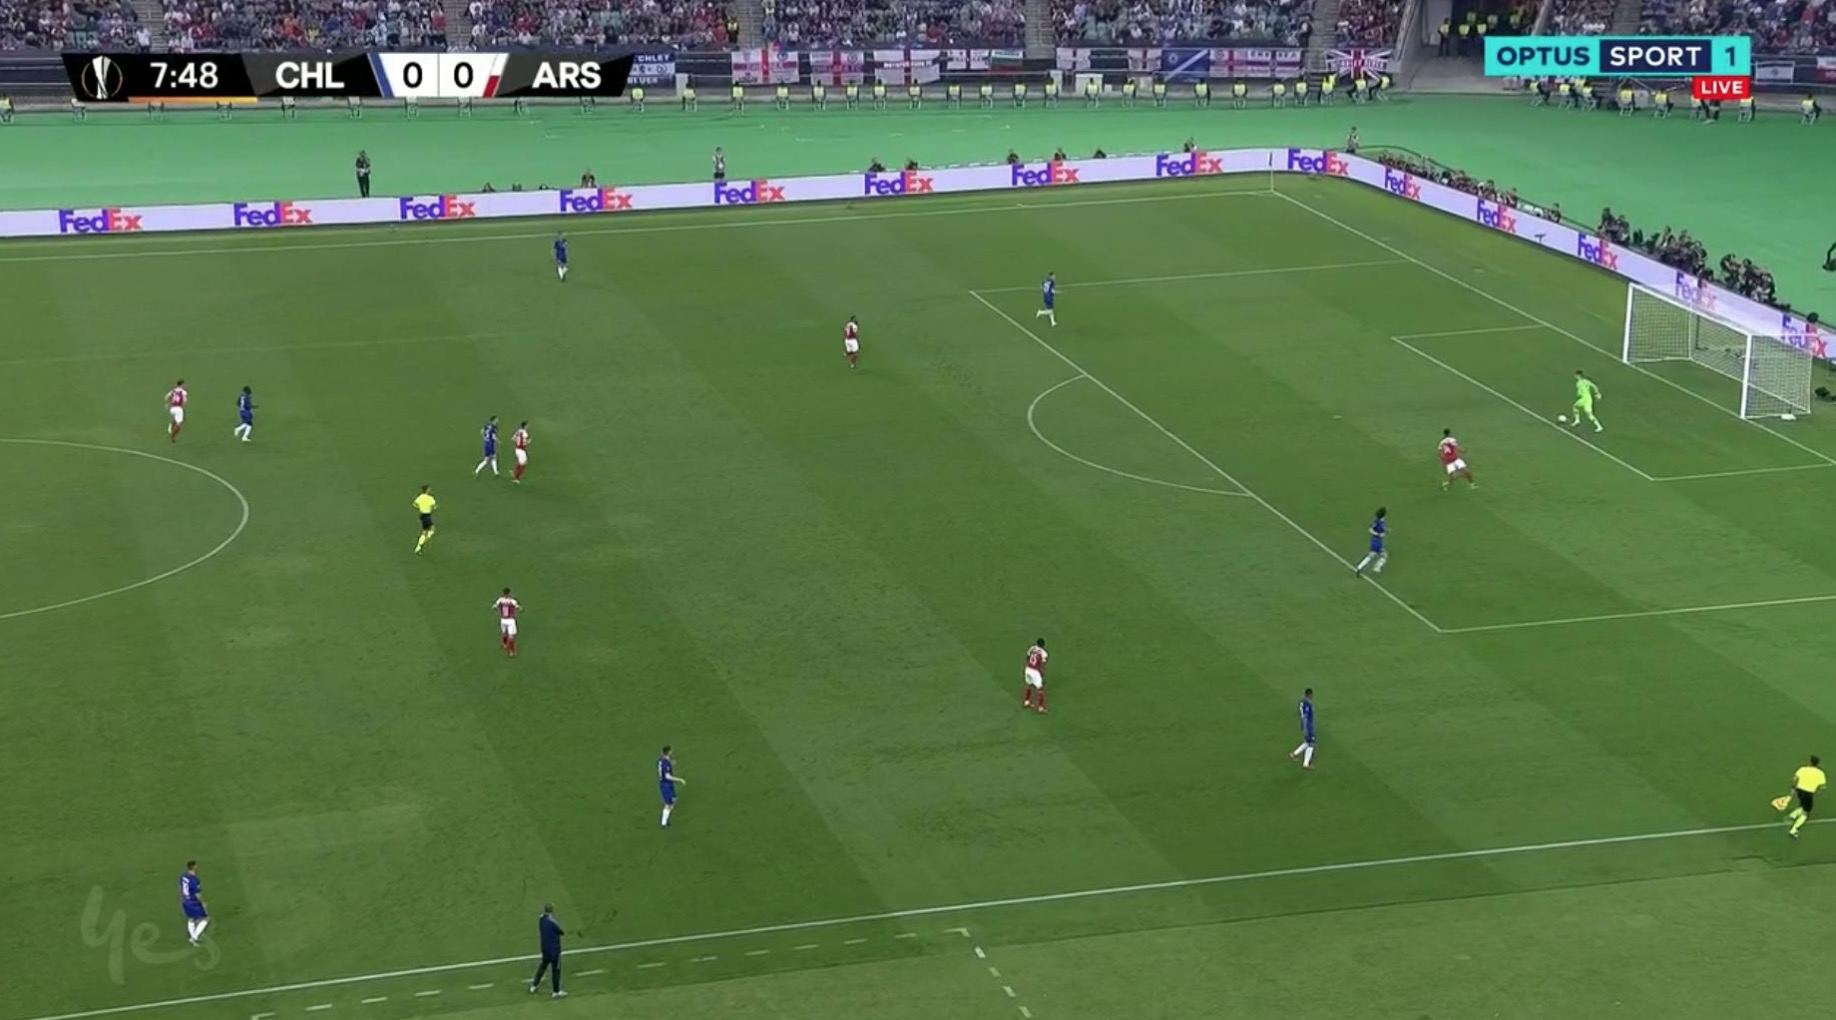

In [2]:
# Load input image (football match broadcasted by TV)
input_image = cv.imread('football-match-2.jpg', cv.IMREAD_COLOR)

# Show the image
Image(filename='football-match-2.jpg')

First things first: we need to determine were the pitch begins and were it ends (the pitch region). So, how do we (humans) do that? 

Well, we know for a fact that the pitch covers a huge area of the image because it is way bigger than the players, the ball, the bars, etc. Besides that, its color is normally some composed by some tons of green, sometimes lighter, sometimes darker, but at the end of the day: green. Last but not least, we know that the pitch is bounded by the four external lines and that it is rectangular. So, we have basically three important information about it that makes us recognize it without a second thought:

- Size;
- Color;
- Shape.

So, how can we use this knowledge to make the computer able to recognize the football pitch? Let's find out.

## Size and color

The information about **size in an image can be translated as the number of pixels contained in a region**. That is justified by the intuitive meaning of an area, for exemple, the area of a square is the multiplication of one side by the other, which can be done easily with an image. So, we can also tell that the size information is directly connected to the color information, because we could not tell the size of the pitch if the color was the same through the whole image! Or even if the image was in grayscale it would make it harder to do our task because we would loose very important information.

So, knowing that the pitch covers the majority of the frame and that it is basically green, how can we take advantage of that? Simple, we could tell the computer to paint all the non-green pixels of the image with, lets say, black and leave the green ones untouched, right? That seems accurate enough, but how do the computer know which pixels are green?

The image is represented as a matrix (if grayscale) or as at least 3 matrices (if colored), where the size of each matrix is the image's size and the values of each coordinate can represent several aspects of the real image, like the intesity of each color composing it (case of RGB representation); or color, pureness of the color and light intensity (HSV representation), etc.

Well, to easily select a color we can use the HSV representation because, unlike RGB, it represents them as small range of values going from 0 to 179.

We can see that green color is at about 50 in Hue:

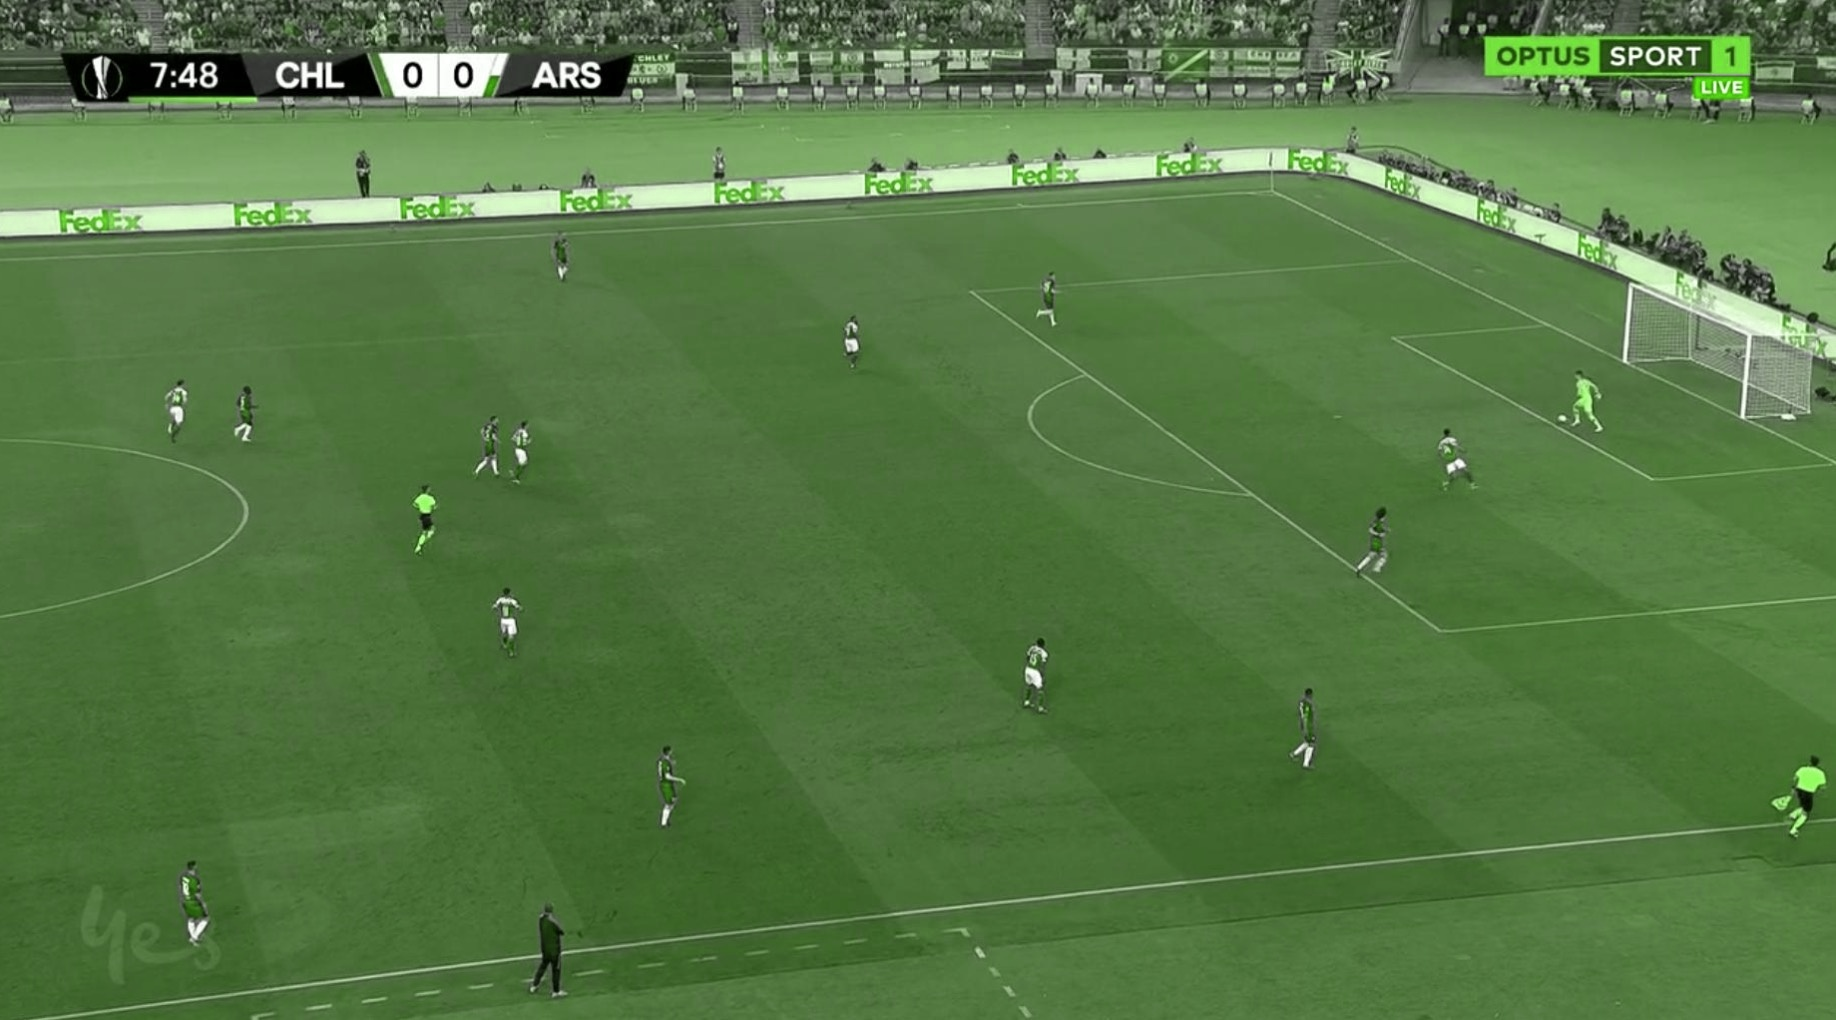

In [3]:
# Make all colors green (except white, black and gray)
dummy_image = cv.cvtColor(input_image, cv.COLOR_BGR2HSV)
dummy_image[0:,0:,0] = 50
dummy_image = cv.cvtColor(dummy_image, cv.COLOR_HSV2BGR)

# Show the image
cv.imwrite('HSV_green.jpg', dummy_image)
Image(filename='HSV_green.jpg')

So, if we make tell the computer to paint everything that is not Hue = 50 as black, we should have basically the pitch in green and everything else in black, right? Let's see:

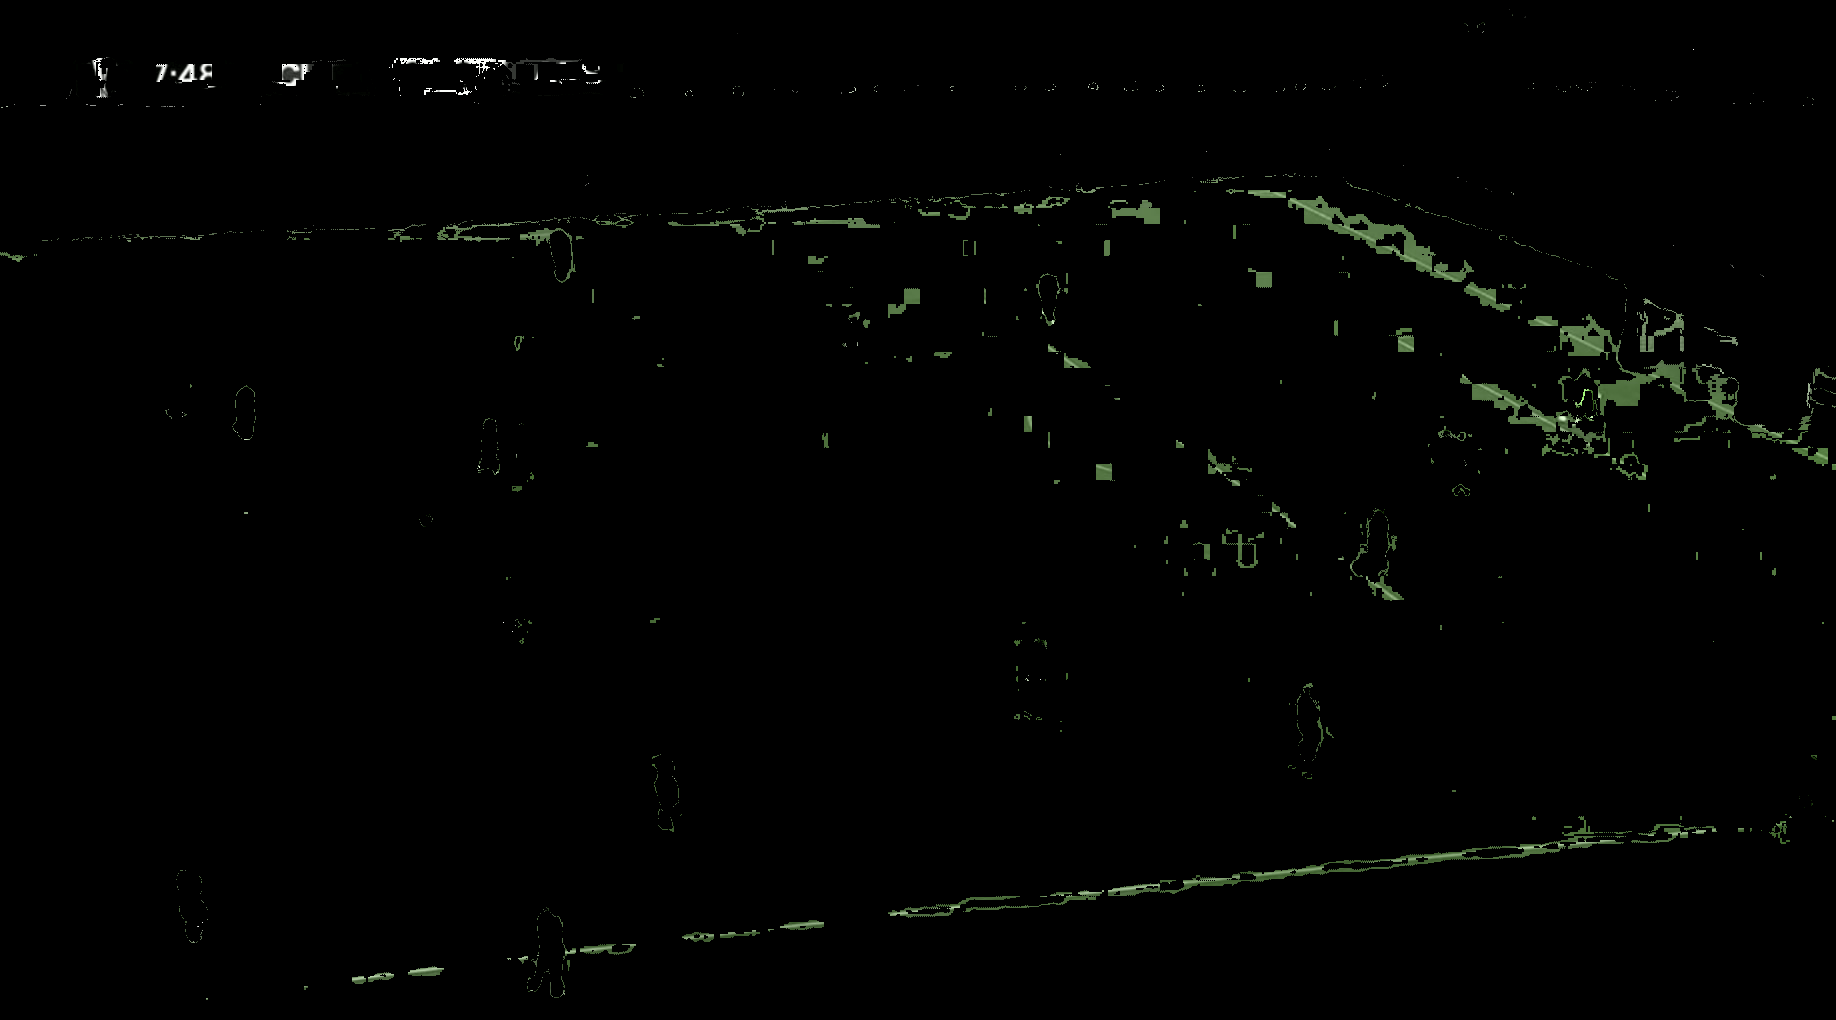

In [4]:
# Convert the image to HSV
pitch_image = cv.cvtColor(input_image, cv.COLOR_BGR2HSV)

# Iterate over the image 
for i in range(pitch_image.shape[0]):
    for j in range(pitch_image.shape[1]):
        if pitch_image[i,j,0] != 50:
            pitch_image[i,j,2] = 0

# Convert the image back to RGB to be able to show it
pitch_image = cv.cvtColor(pitch_image, cv.COLOR_HSV2BGR)

# Show the image
cv.imwrite('is_it_the_pitch.png', pitch_image)
Image(filename='is_it_the_pitch.png')

It is not exactly what we expected... so, we can obviously see that the pitch is formed by different tons of green, so how could we expect to segment it with only the tone with Hue=50?

To have a better understanding of the Hue distribution for this image, we can check its histogram, which counts the number of occurrences of each tone:

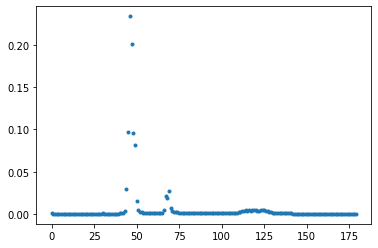

In [5]:
hsv_img = cv.cvtColor(input_image, cv.COLOR_BGR2HSV)
hsv_img = cv.blur(hsv_img,(5,5))

hist = np.zeros(180)
for i in range(hsv_img.shape[0]):
    for j in range(hsv_img.shape[1]):
        hist[hsv_img[i][j][0]] += 1
hist = hist/(hsv_img.shape[0]*hsv_img.shape[1])

# Plot normalized histogram
plt.plot(hist, marker='.', linestyle='none')
plt.show()

Looking at the histogram we can see that the range between, roughly saying, 40 and 50 contain the most number of pixels in the image, so we can define a lower limit and a upper limit to keep in the image, paiting everything else in black.

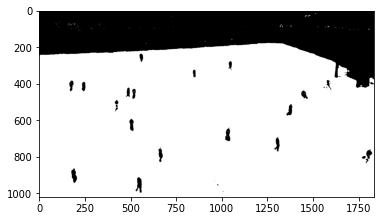

In [6]:
# Define the range of the green color desired
lower_green = np.array([40,60,60])
upper_green = np.array([55,200,165])

# Define the threshold to get only grass green
mask = cv.inRange(hsv_img, lower_green, upper_green)

# Show the mask created (white is the pitch, black is not the pitch)
plt.imshow(mask,cmap='gray')
plt.show()

We can make a bitwise AND with the image and the mask:

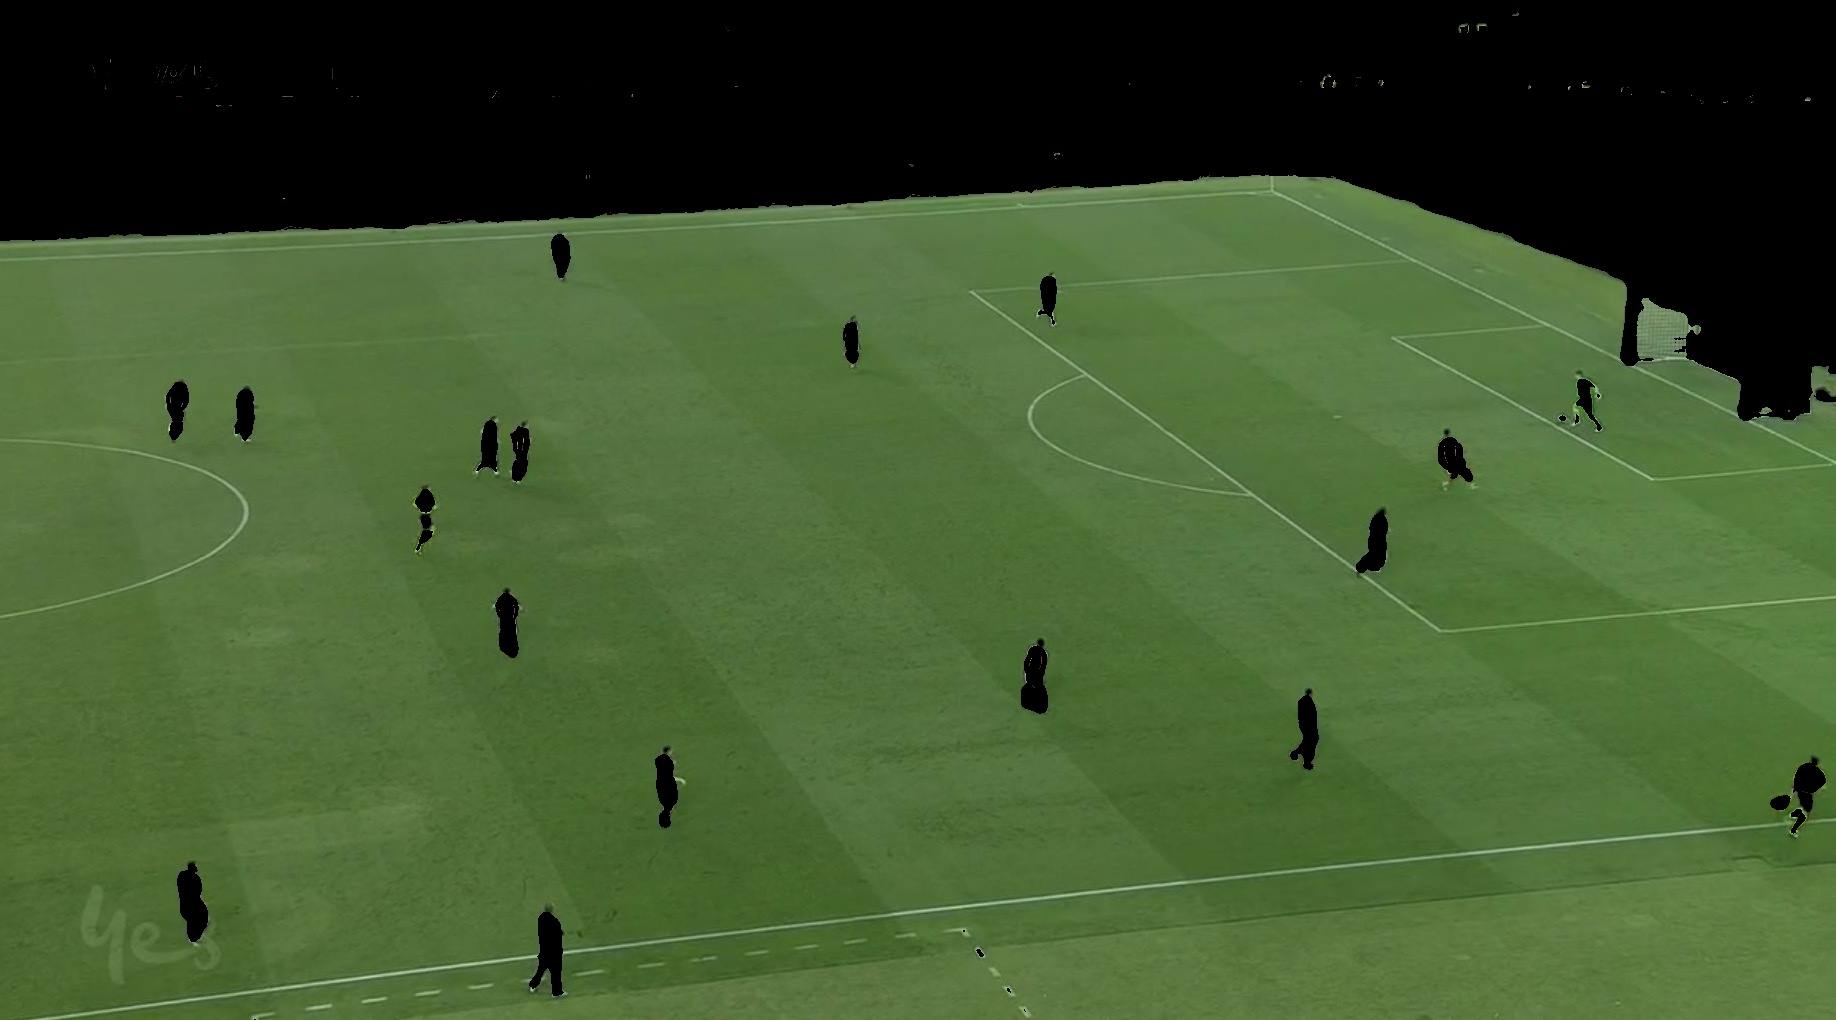

In [7]:
# Bitwise-and mask and input image
pitch_img = cv.bitwise_and(input_image, input_image, mask=mask)

cv.imwrite('pitch_img.jpg', pitch_img)
Image(filename='pitch_img.jpg')

As we can see, we were able to roughly extract the "grass" area of the image (which contains more than only the pitch). We can also see though, that there is some noise at the supporters stands, at the goal and some at the technical area. To remove the ones from the supporters we can try applying a morphological transformation called **Opening**.

The Opening operation consists of an erosion followed by a dilation. For that we will use the black and white image (the mask we got in the previous process), erode the white part to supress the noisy elements at the supporter's stands and then apply dilation to keep the other parts of the image untoutched.

About the specifics of the problem, we will use a 5x5 kernel consisting of a one's matrix.

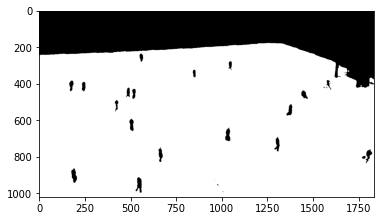

In [8]:
# Build the kernel matrix
kernel = np.ones((5,5), np.uint8)

# Apply the Opening transformation to the mask
mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)

# Show the mask after Opening
plt.imshow(mask,cmap='gray')
plt.show()

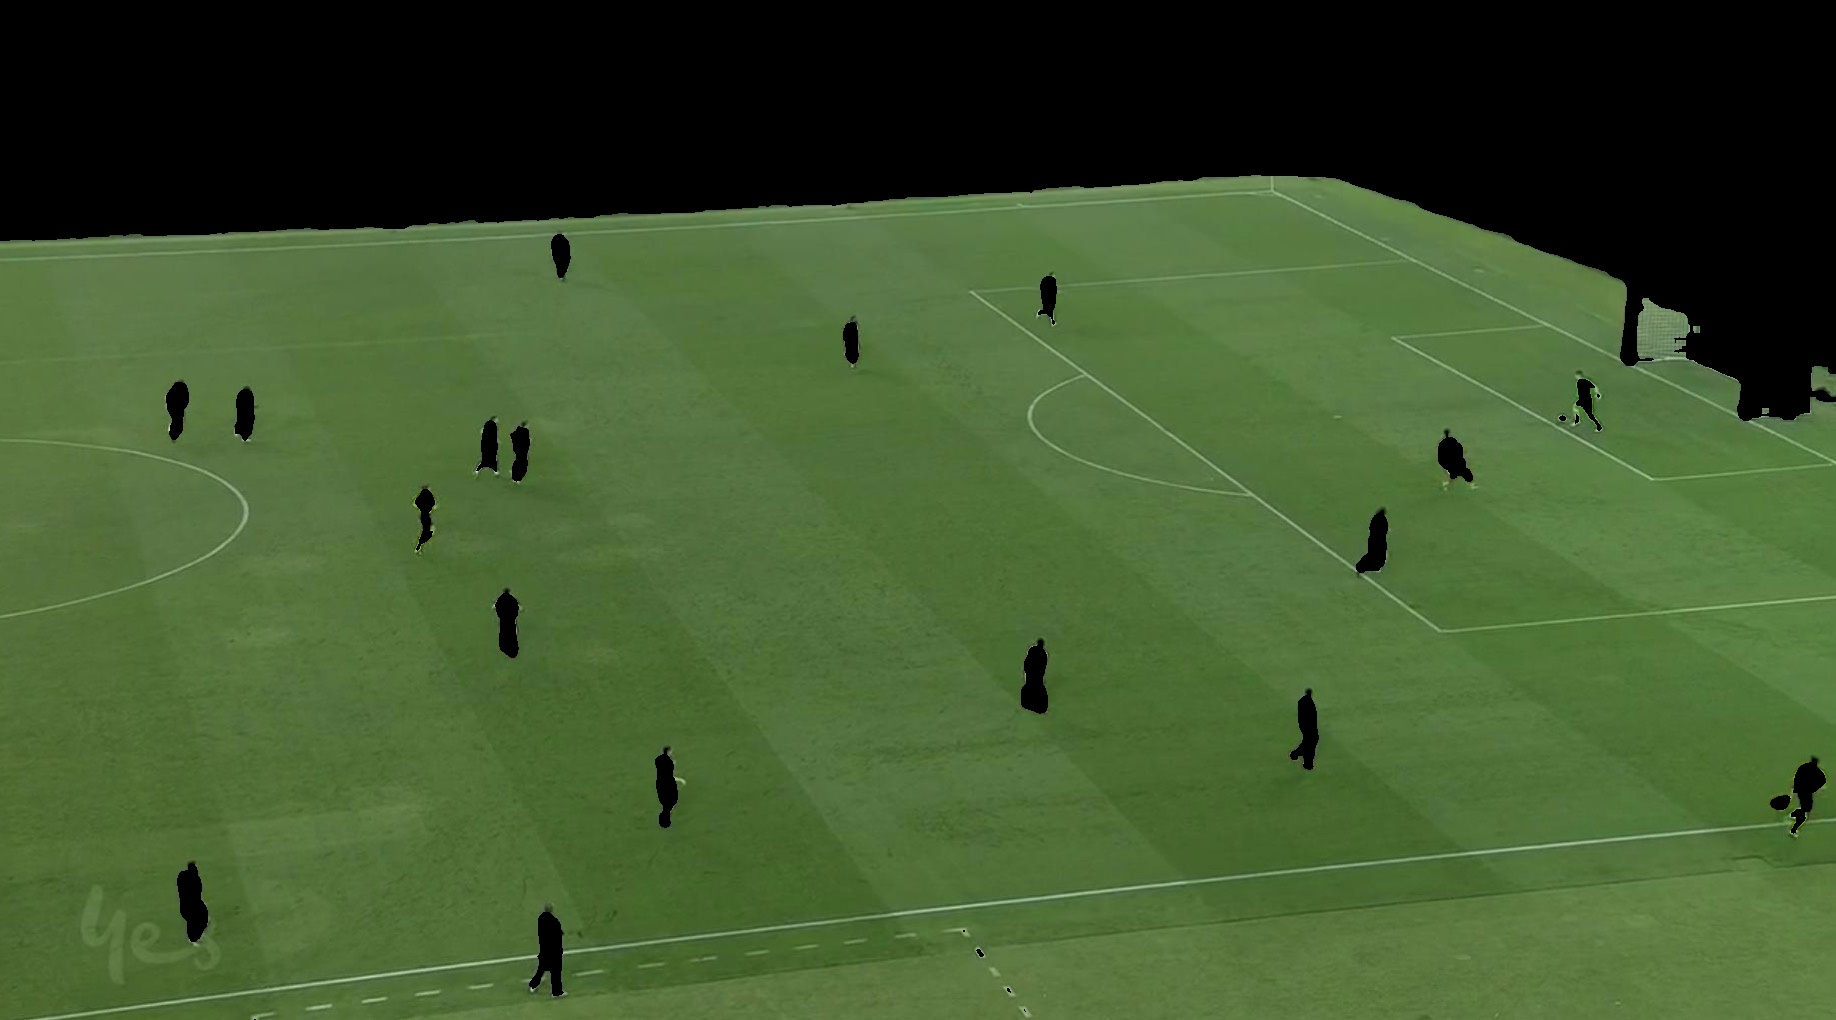

In [9]:
# Recreate output image
pitch_img = cv.bitwise_and(input_image, input_image, mask=mask)

cv.imwrite('pitch_img_opening.jpg', pitch_img)
Image(filename='pitch_img_opening.jpg')

And there we go! The noisy part at the stands are now gone.

So, considering we got the grass part of the image, we can continue to the line detection part of the project, in which we want to determine the limits of the pitch.

## Shape

Shape is also an important aspect of the image to our human eyes. We can detect points, which when combined together create lines, which also combine to create geometric objects (squares, rectangles, circles, semicircles, etc). Right now, we want to find the lines of the pitch, so we need to use the algorithms that give us the possibility to acomplish this task, such as the Canny edge detection algorithm and the Hough Transform.

### Edge detection with Canny algorithm

We are going to use the Canny algorithm to detect the edges in our image of the pitch, which consists of three steps: 

1. Noise filtering using Gaussian Filter;
2. Calculation of magnitude and angle of gradient vector for all pixels of the image;
3. Non-maximum suppression, where it removes the pixels that clearly do not belong to an edge;
4. Hysteresis, where it tries to smooth the edge detection by considering pixels that are not so strong (in relation to the gradient), but are connected to strong edge pixels.

We begin implementation by converting the last image to grayscale, then we apply the Canny Edge Detection function which is already implemented in OpenCV as "cv.Canny(image, threshold1, threshold2, edges, apertureSize, L2gradient)".

This function has 5 arguments:

- image: the input image;
- threshold1 and threshold2: the lower and upper values of threshold for the hysteresis part, respectively;
- edges: the output edge map, same size as image;
- apertureSize: the size of the kernel for the sobel operations;
- L2gradient: "True" for the L2 norm for gradient magnitude calculation and "False" for simple L1 norm.

By experimentation, we found that a kernel size of 3 and L2 norm combined with threholds 1 and 2 equal to 25 and 121, respectively, gave us the best results.

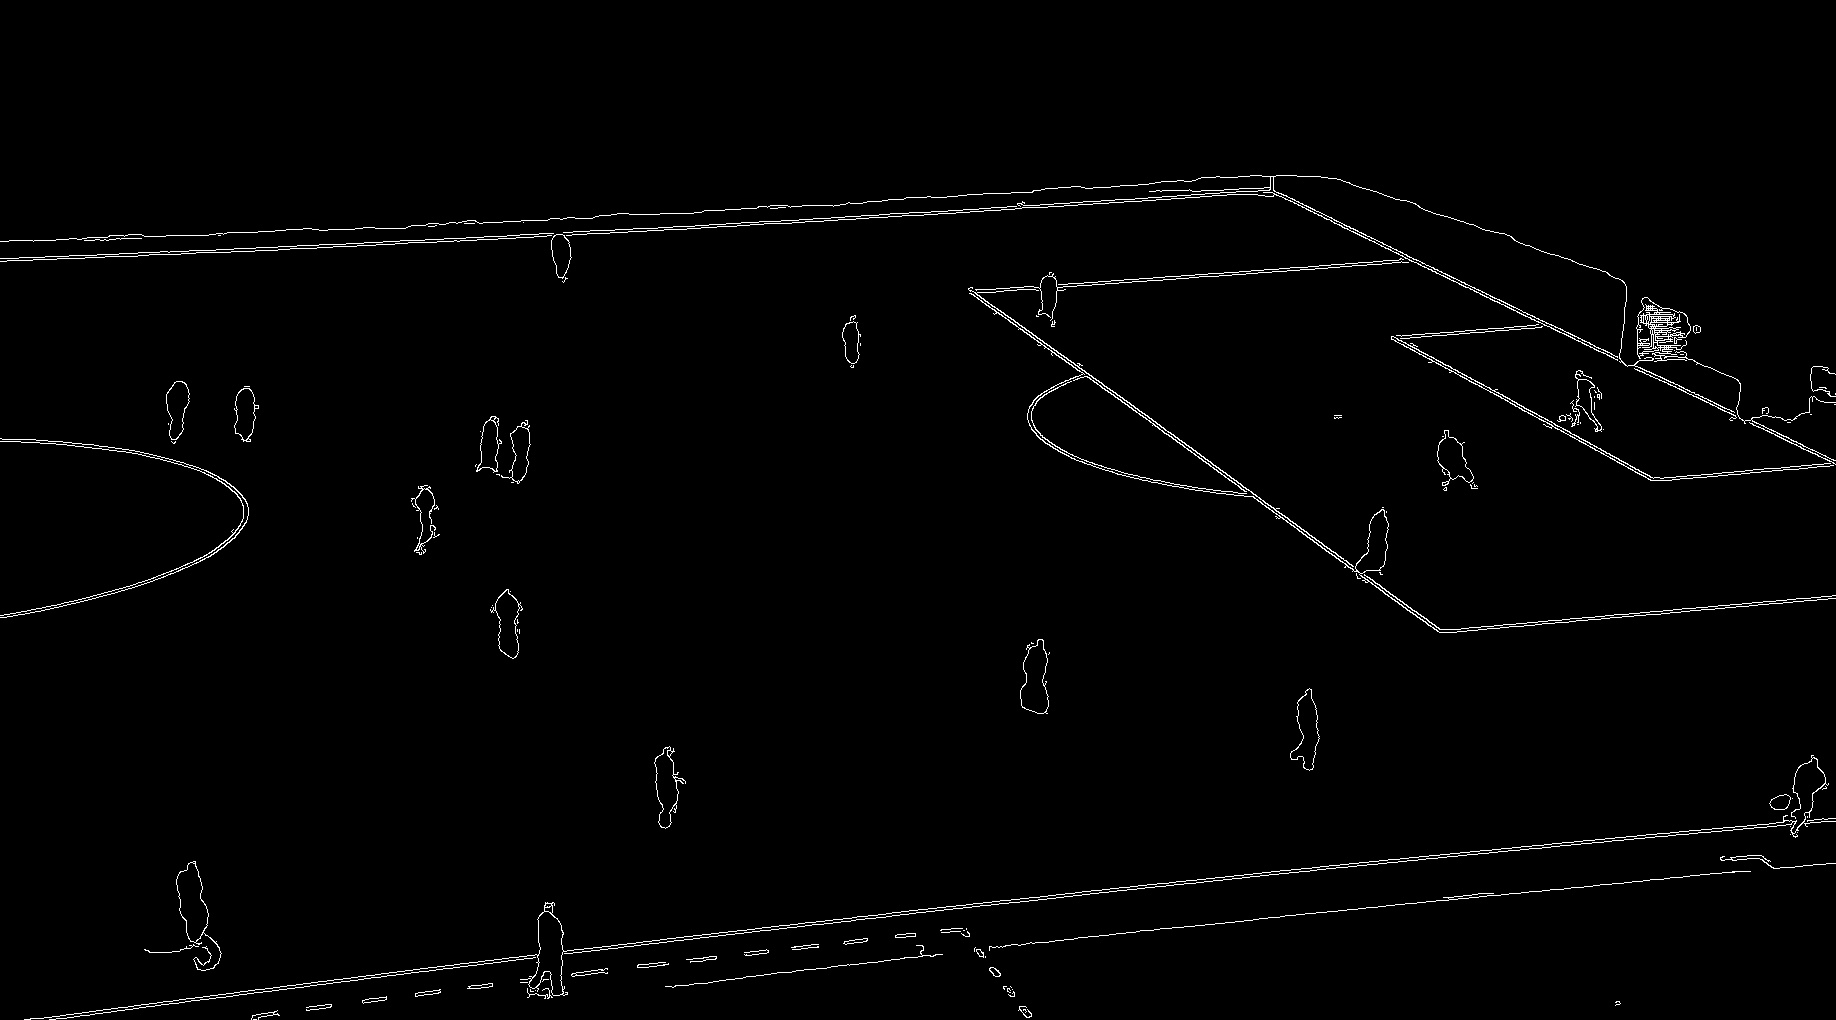

In [10]:
# Convert image to grayscale
pitch_img_GRAY = cv.cvtColor(pitch_img, cv.COLOR_BGR2GRAY)

# Apply Canny
edges = cv.Canny(pitch_img_GRAY, 25, 121, apertureSize=3, L2gradient=True)

# Write Canny output image
cv.imwrite('canny_output.jpg', edges)

Image(filename='canny_output.jpg')

It is good to see that all the four external lines and the internal lines of the pitch were found by the Canny algorithm. But we need to take a closer look at two things: 

1. The lines are in reality two thin lines with a gap between them. That happens because the Canny algorithm finds the thinner edges possible.
2. Along with the lines we want to highlight we got all the other edges (lines and contours) that are not of interest to us right now. 

To solve problem number 1 we can apply the morphological transformation Closing with a white kernel. That is going to join the two thin lines into one thicker one. 
And to solve problem number 2, we can apply already used Opening transformation, for it is going to erode the white lines, erasing the thin ones.

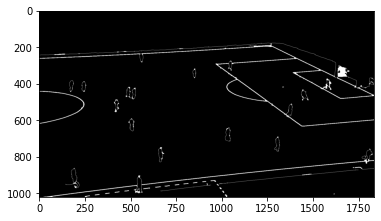

In [11]:
# Apply the Closing transformation to the edges
pitch_edges = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)

# Show the mask after Opening
plt.imshow(pitch_edges,cmap='gray')
plt.show()

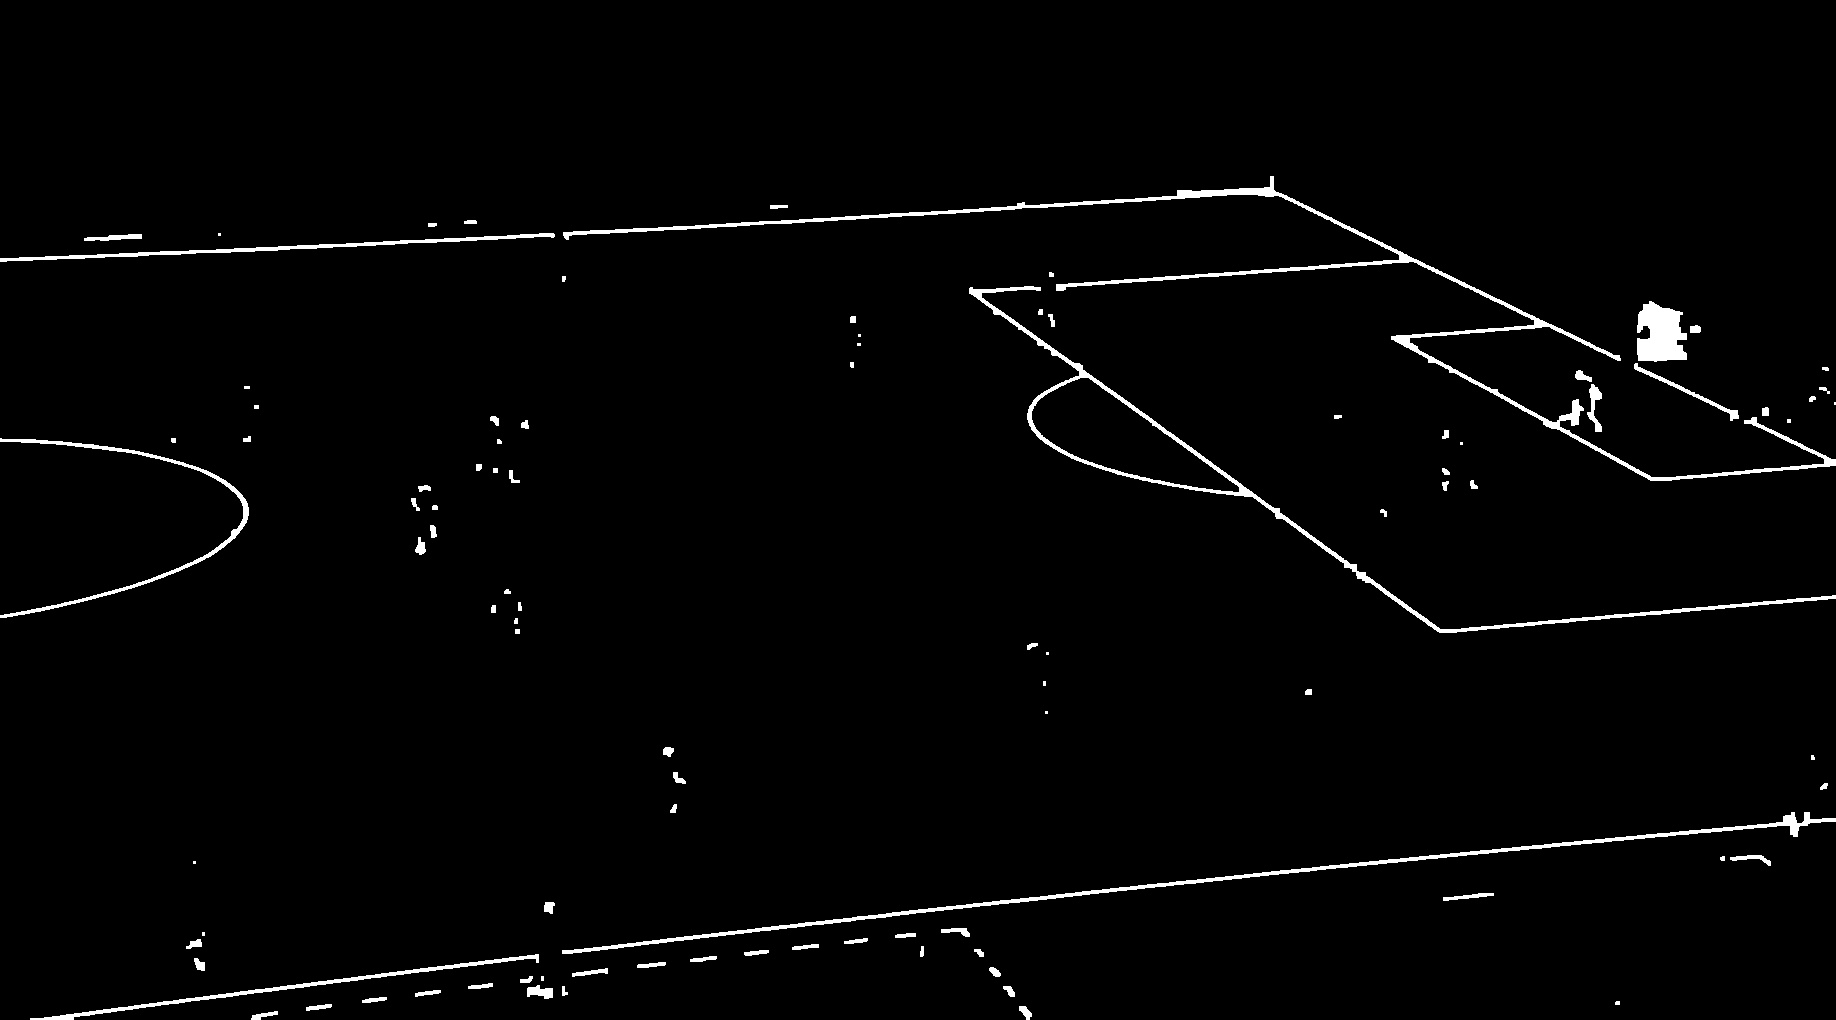

In [12]:
# Apply the Opening transformation to the edges
kernel = np.ones((3,3), np.uint8)
pitch_edges = cv.morphologyEx(pitch_edges, cv.MORPH_OPEN, kernel)

# Write processed Canny output image
cv.imwrite('processed_canny_output.jpg', pitch_edges)

Image(filename='processed_canny_output.jpg')

Well, not exactly the best visual result, but it worked quite nicely to our purposes, because we are now going to use the Hough Transform to really highlight those lines.

### Hough Transform

Explaning it in short details, the Hough Transform keeps track of the family of lines that passes by each pixel, so when the same line passes by several pixels it is detected as a real line in the image. To use the OpenCV implementation we have two options: the standard Hough Transform and the probabilistic Hough Transform.

- The standard Hough Transform: 

This algorithm will give us the lines that have more points in it, based on some threshold that we are going to pick. The OpenCV function for this is: **cv.HoughLines(image, rho, theta, threshold, lines, srn, stn, min_theta, max_theta)**.

The first parameter is the input image containing the edges from Canny algorithm; the parameters rho and theta are the resolution of distance and angles (polar coordinates); the threshold parameter is the minimum amount of points that the lines need to pass by for the algorithm to consider it; and the others we will not use.

The threshold value of 400 gave the best results.

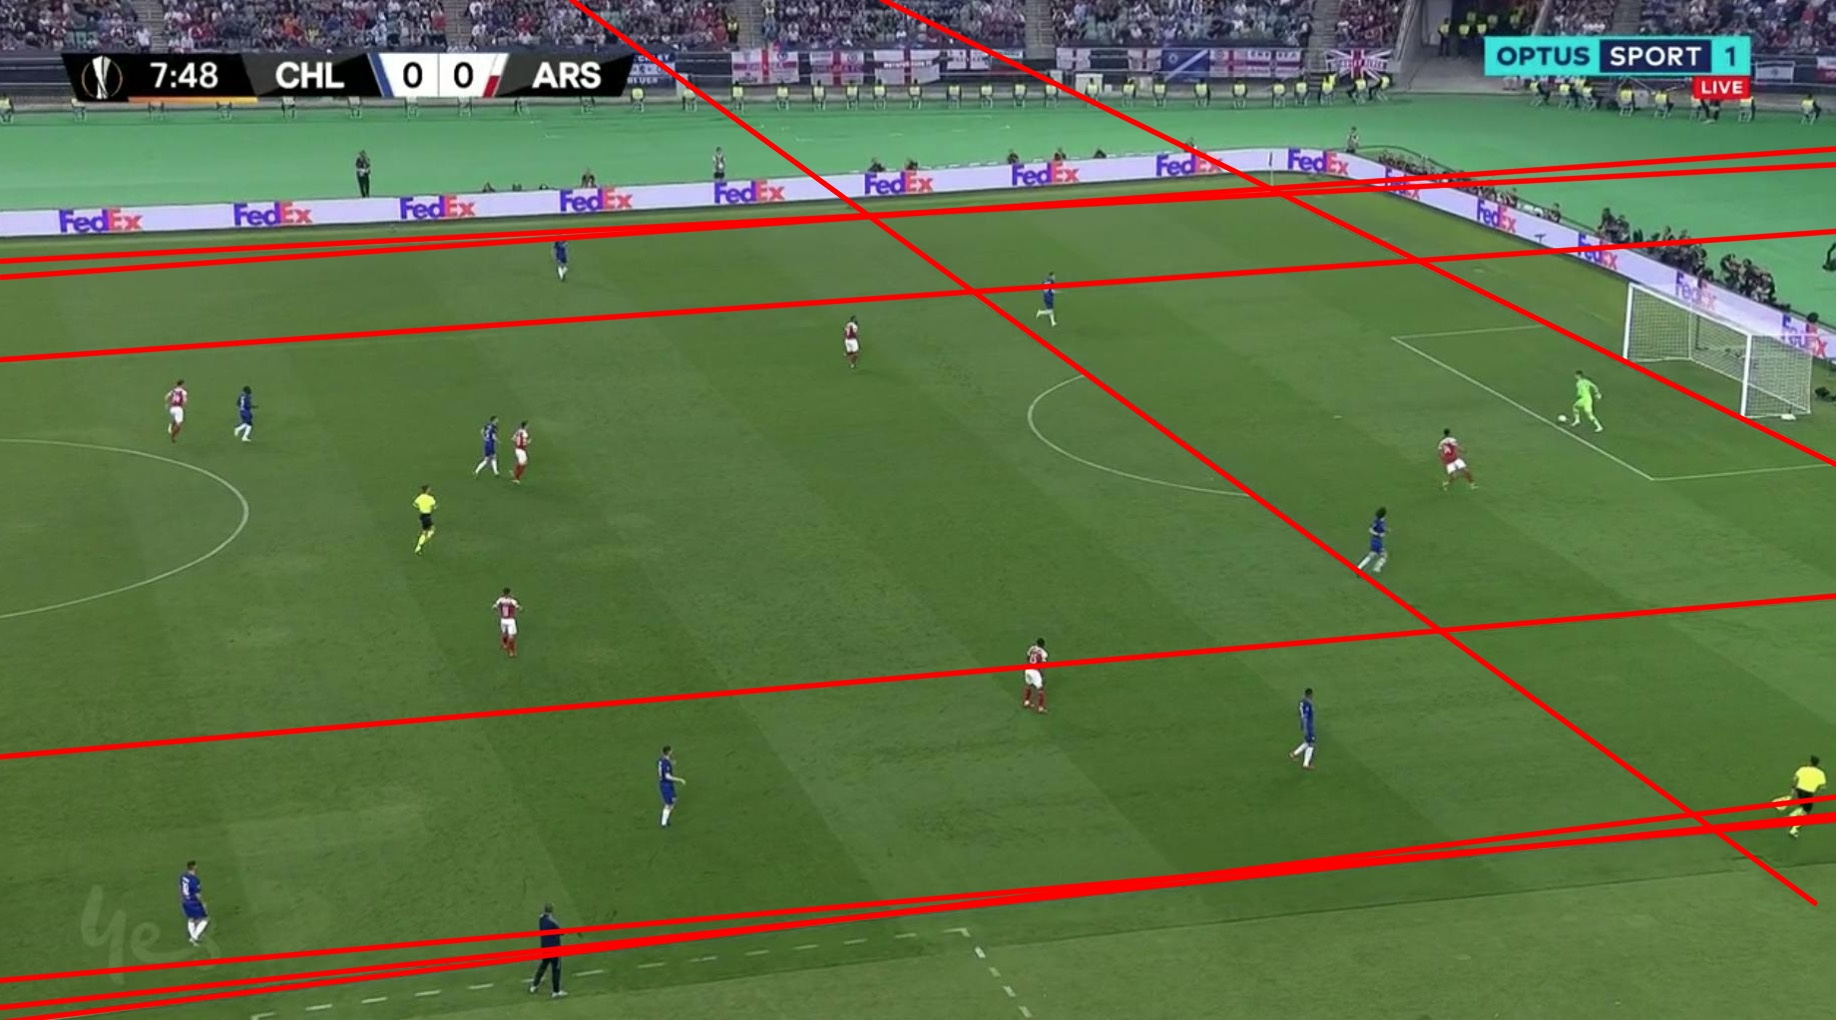

In [13]:
import math

# Copy input image
pitch_hough = input_image.copy()

# Detect lines using Hough Transform with threshold of 400 points
lines = cv.HoughLines(pitch_edges, 1, np.pi / 180, 400, None, 0, 0)

# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
        pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
        cv.line(pitch_hough, pt1, pt2, (0,0,255), 3, cv.LINE_AA)

# Write Hough Transform output image
cv.imwrite('hough_lines.jpg',pitch_hough)

Image(filename='hough_lines.jpg')

We can see many lines detected in the above image, but in general they represent the real lines of the pitch (although some of them were left out). That happens because the Hough Transform messes up a little bit when there is noise in the image, so to compensate that the Probabilistic Hough Transform was created.

- The probabilistic Hough Transform:

I am not going into the details of the difference between the two algorithms, but this second is an optimization of the first one, because basically it does not go over all the points, but it picks a random subset of them. Another difference is that it represent the lines for the starting point and the endpoint, not by distance and angle.

The OpenCV implementation is as follows: **cv.HoughLinesP(image, rho, theta, threshold, lines, minLineLength, maxLineGap)**.

The first 5 arguments are exactly like the standard hough transform, but the last two set the minimum length for a line to be detected and the maximum gap between two points of the same line. The values were choosen empirically.

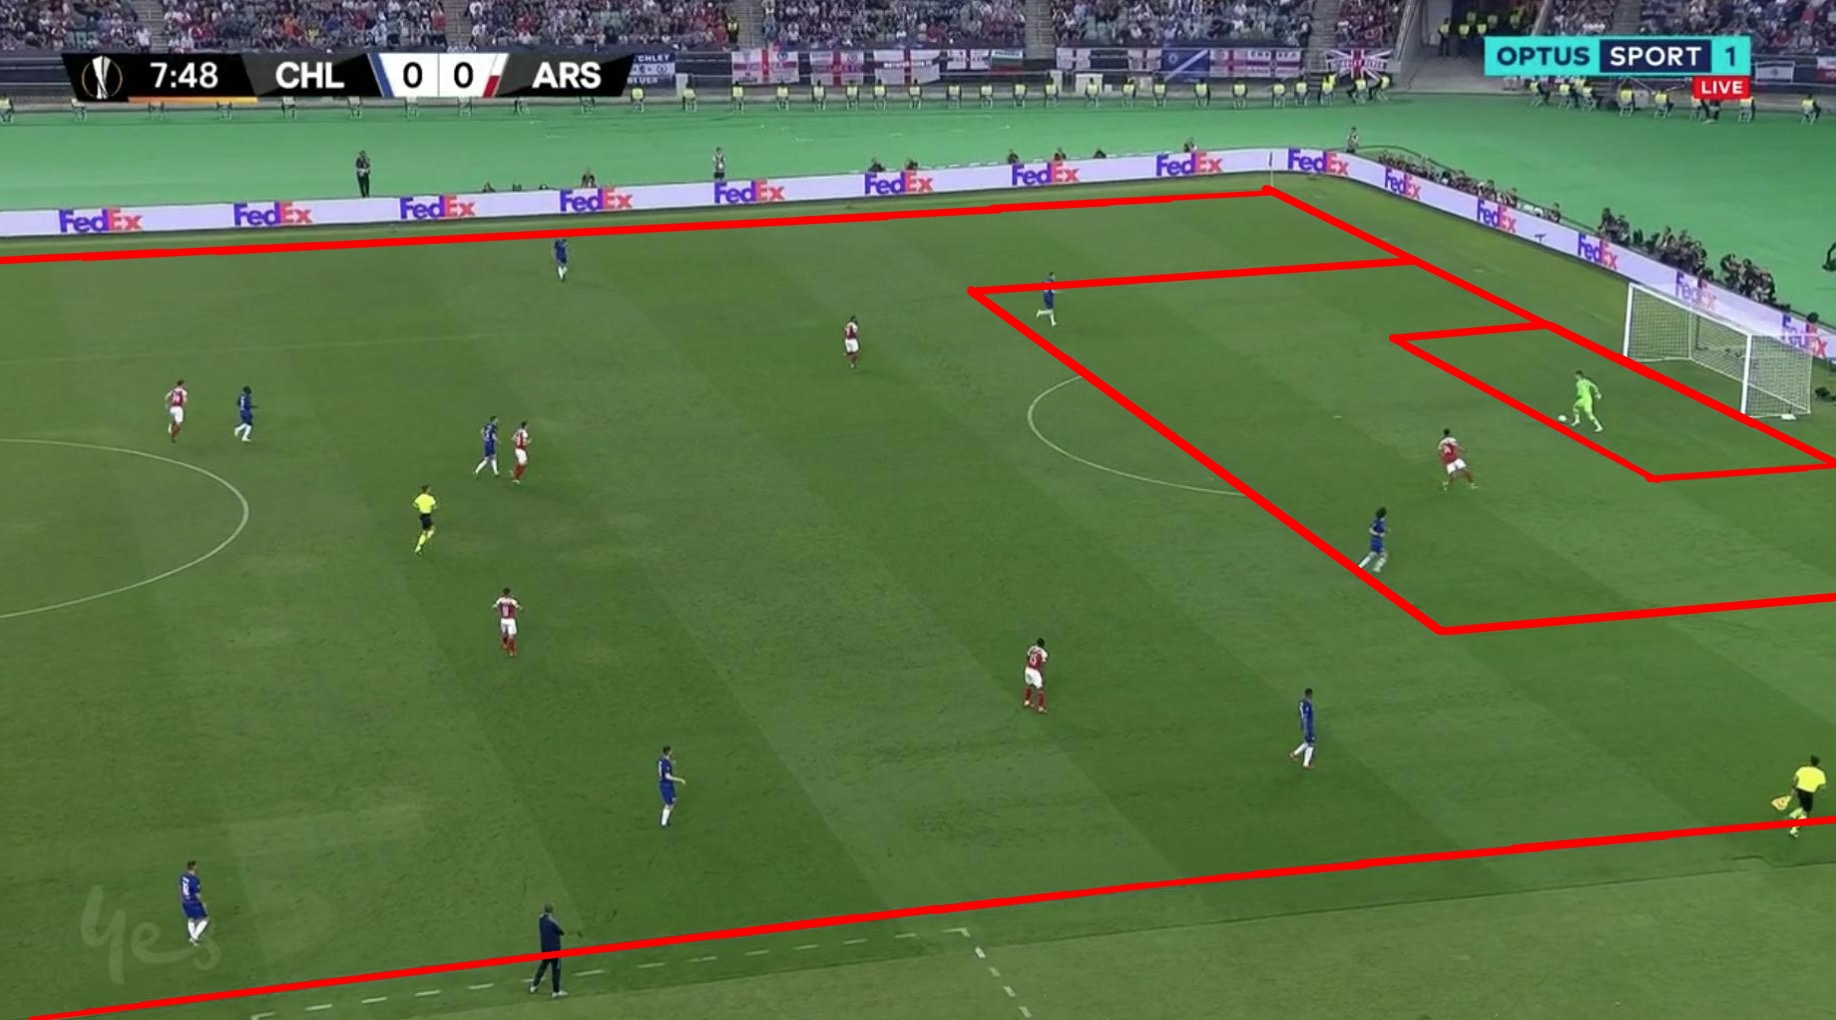

In [14]:
# Copy input image
pitch_hough_P = input_image.copy()

# Detect lines using Hough Transform with threshold of 150 points
linesP = cv.HoughLinesP(pitch_edges, 1, np.pi / 180, 150, None, 155, 25)

# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(pitch_hough_P, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

# Write Probabilistic Hough Transform output image
cv.imwrite('hough_lines_P.jpg',pitch_hough_P)

Image(filename='hough_lines_P.jpg')

Well, I guess we can consider that the process' output is quite satisfactory. We wanted to highlight the pitch lines and they are almost all in red color! The thing is that the Hough Transform does not take into account rounded objects, and that is why the central circle and the half circle near the penalty mark were not detected. For those, we will need to take a different approach, but it is not the goal right now.

As a next step, we move on to detecting the human figures that interact with the pitch.

## Human detection

To be able to detect human figures we are going to use the OpenCV function "findContours". Contours are no more than a loop of connected pixels, in the sense of having the same color.

So first thing we do is to take the pitch image in grayscale and turn it into a binary image.

In [15]:
# Copy input image
find_contours_image = input_image.copy()

# Create binary image
im_bw = cv.threshold(pitch_img_GRAY, 0, 255, cv.THRESH_BINARY)[1]

We apply some blur (filtering) to the image and we extract its edges. Note that at this point we use threshold values of 253 and 255, and that is because at this point we don't want to get stuck with the pitch lines, we need to fine the thinner edges of the players and humans in general.

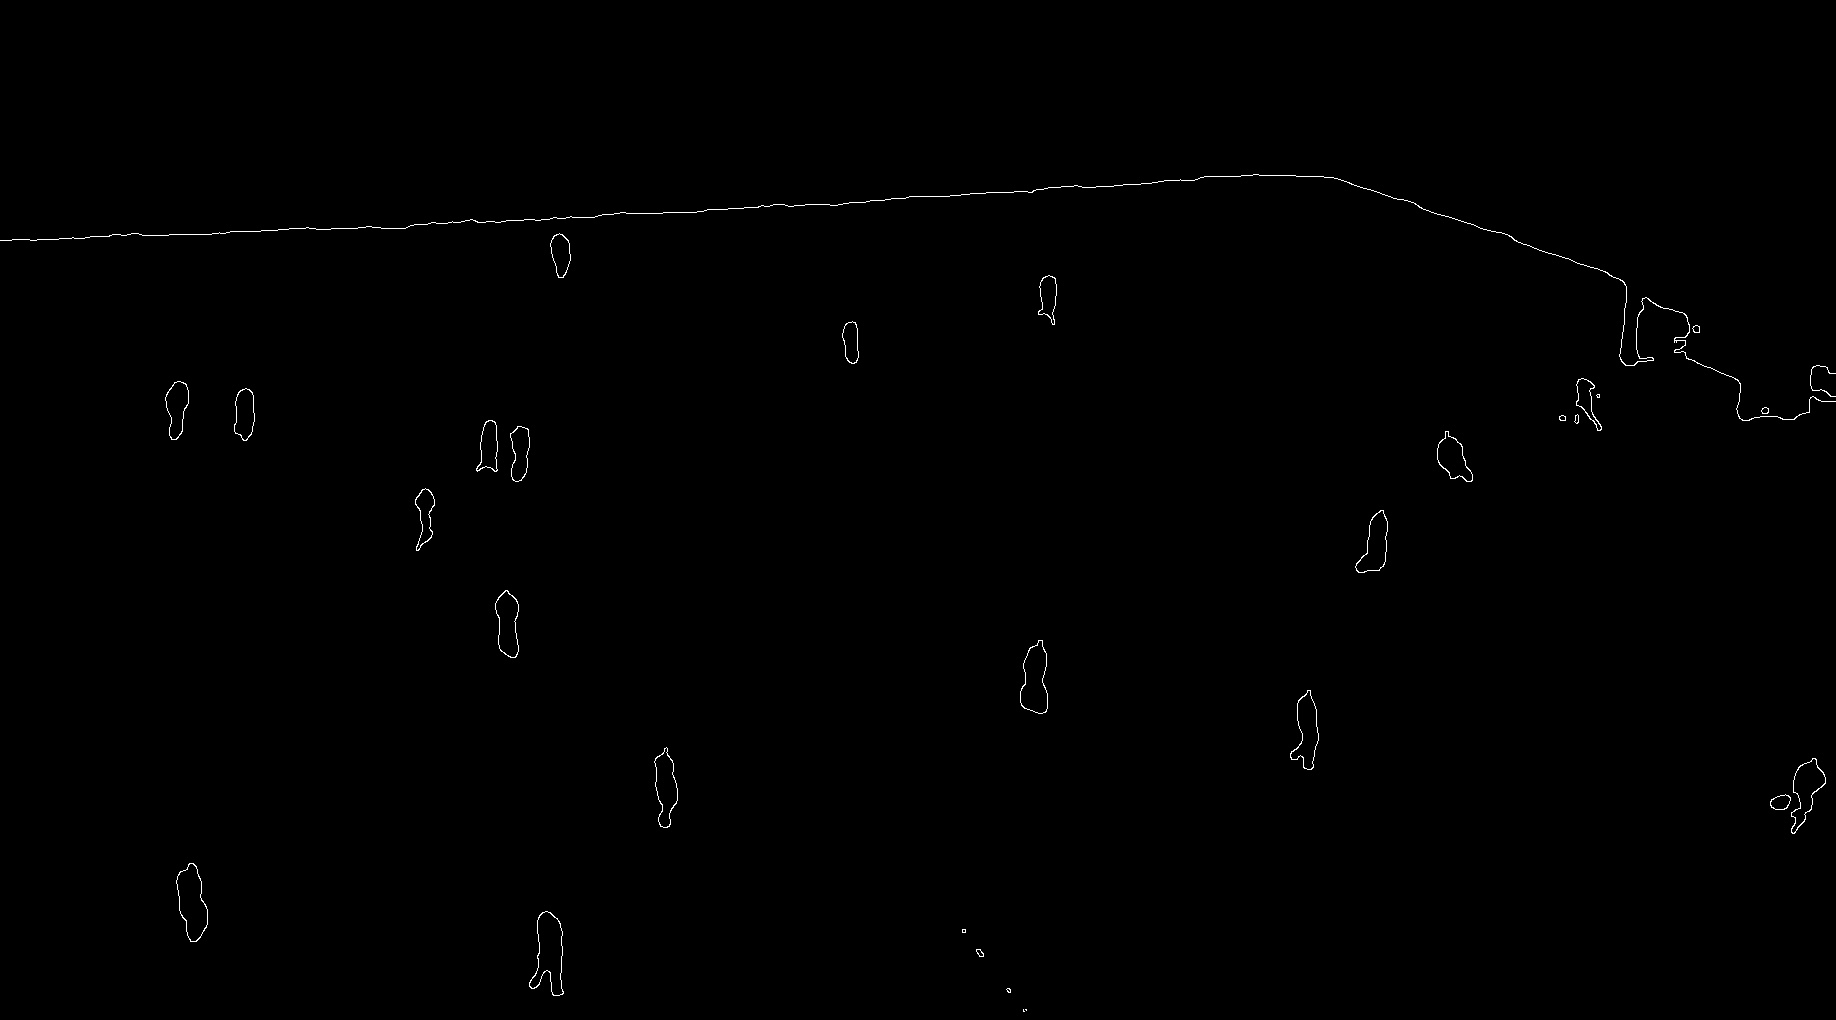

In [16]:
# Blur BW image
im_bw = cv.blur(im_bw, (3,3))

# Canny Edge detection
contours_edges = cv.Canny(im_bw, 253, 255, apertureSize=3, L2gradient=True)

# Write Probabilistic Hough Transform output image
cv.imwrite('contours_edges.jpg',contours_edges)

Image(filename='contours_edges.jpg')

And now we use the "findContours" and the "minAreaRect" functions to draw bounding boxes on the humans.

Two threshold values for the minimum and maximum contour area were defined to filter the contours that do not represent humans.

58  contours.
37  boxes.


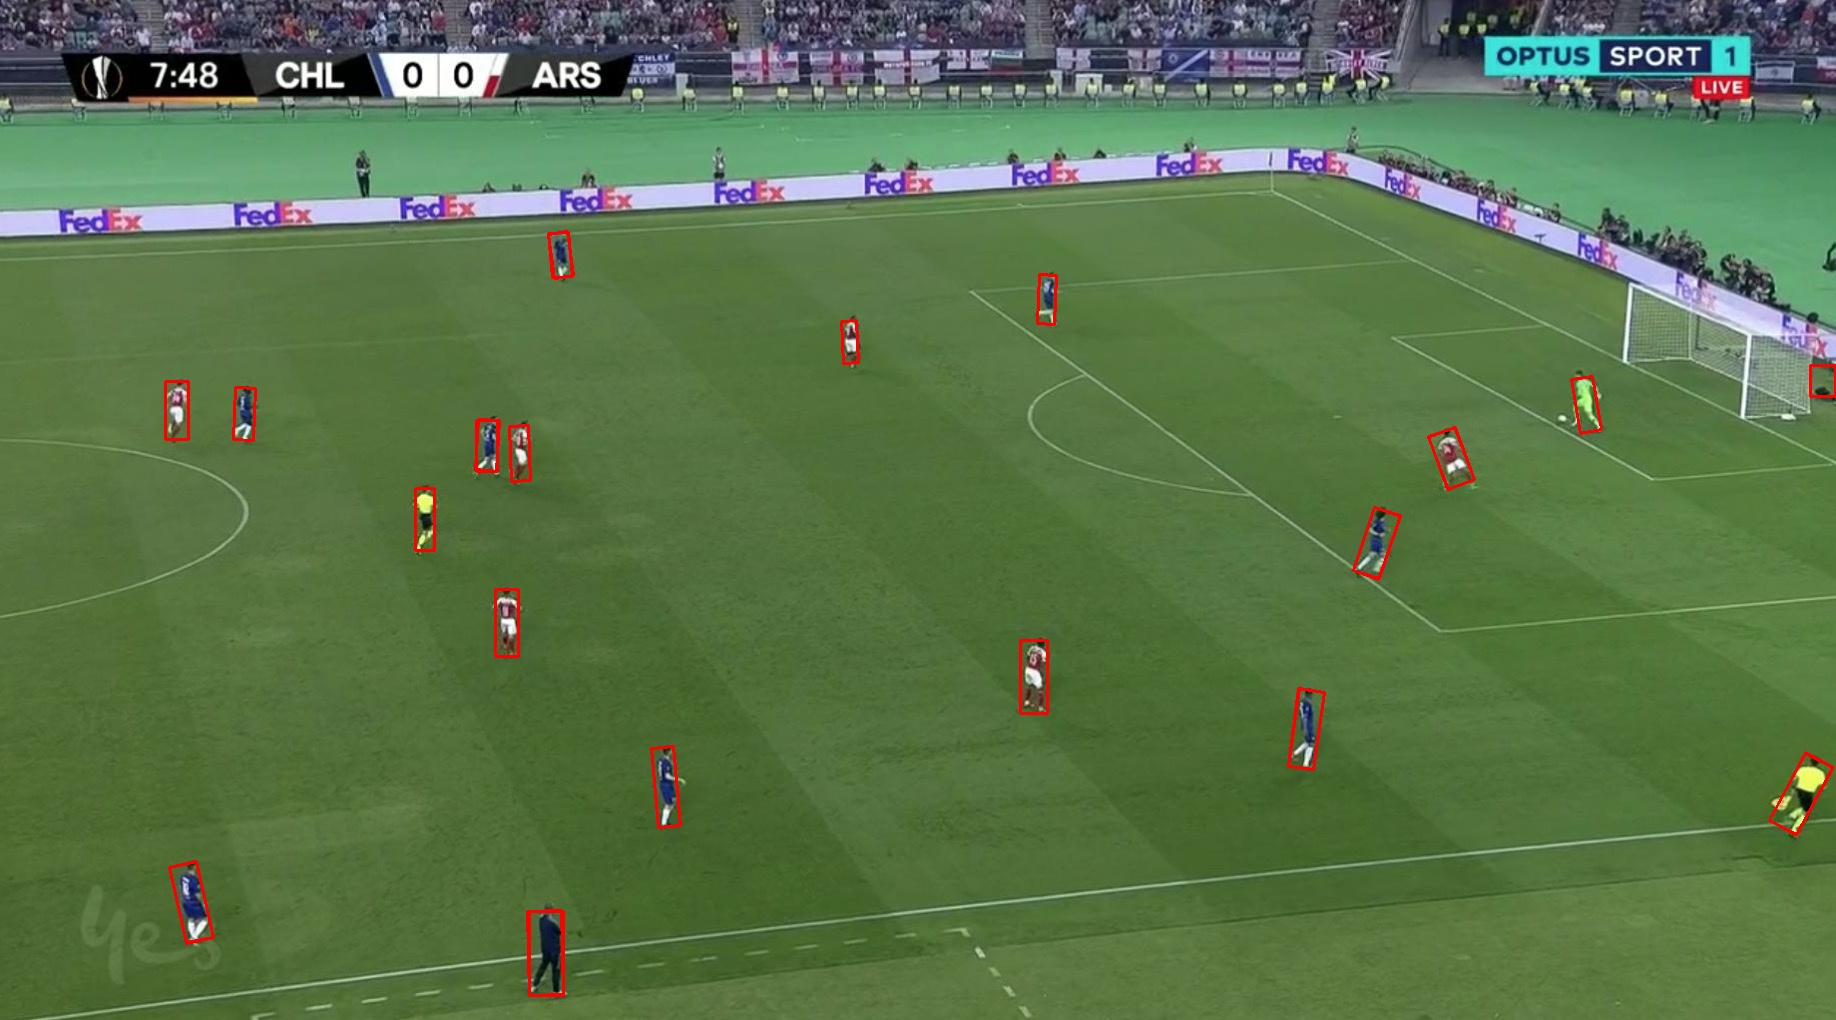

In [20]:
# Find contours
contours, hierarchy = cv.findContours(contours_edges, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

boxes = 0
minArea = 500.0
maxArea = 3000.0
# Draw contours
for cnt in contours:
    rect = cv.minAreaRect(cnt)
    if rect[1][0]*rect[1][1] > minArea and rect[1][0]*rect[1][1] < maxArea:
        box = cv.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(find_contours_image,[box],0,(0,0,255),2)
        boxes += 1

print(len(contours), ' contours.')
print(boxes, ' boxes.')

# Write Contours output image
cv.imwrite('contours.jpg', find_contours_image)

Image(filename='contours.jpg')

As a result we see that all humans that interact with the pitch were detected, but some of them have more that one bounding box on him (hence the number of 37 boxes drawn out of 18 humans) and something behind the goal was also detected.